In [15]:
import pandas as pd
import numpy as np
import prince

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [16]:
# lecture des données 

marketing = pd.read_csv("marketing_campaign.csv", encoding="utf-8", sep= "\t")

# affichage des colonnes

marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [56]:
# on crée la variable Total_Enfants qui comptabilise enfants + ados
# puis on la transforme en quali

marketing['Total_Enfants'] = marketing['Kidhome'].astype(int) + marketing['Teenhome'].astype(int)
marketing['Total_Enfants'] = marketing['Total_Enfants'].astype('category')
Y = marketing['Total_Enfants']

In [57]:
# on sélectionne les variables qui correspondent aux types d'achat (Mnt)

mnt_columns = [col for col in marketing.columns if col.startswith("Mnt")]
X = marketing[mnt_columns]

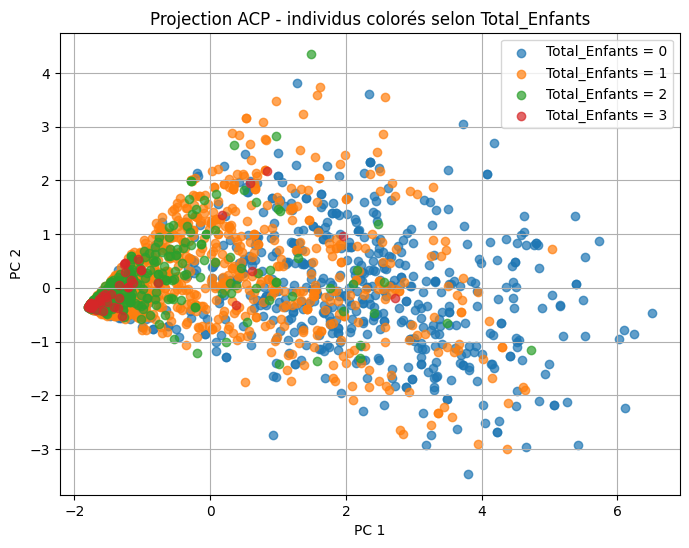

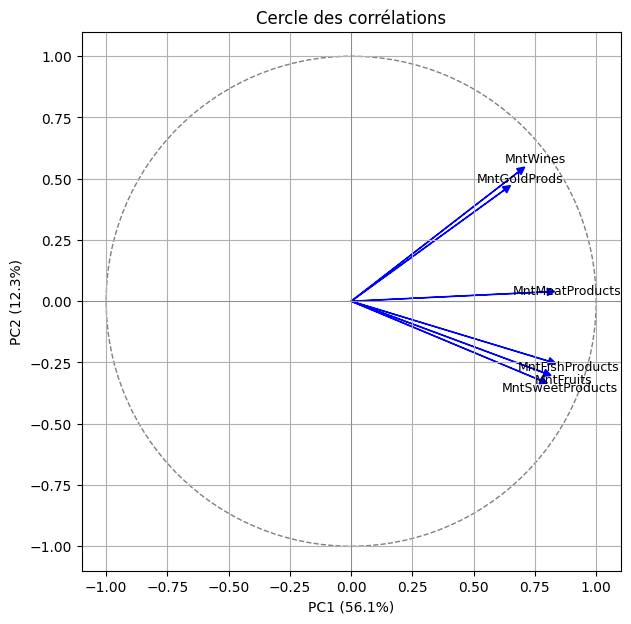

In [58]:
# on fait une ACP sur les données Mnt

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))

for val in sorted(Y.unique()):
    plt.scatter(
        X_pca[Y == val, 0],
        X_pca[Y == val, 1],
        label=f'Total_Enfants = {val}',
        alpha=0.7
    )

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Projection ACP - individus colorés selon Total_Enfants")
plt.legend()
plt.grid(True)
plt.show()

pcs = pca.components_
explained_var = pca.explained_variance_ratio_

# Coordonnées des variables dans le plan (Dim 1 et Dim 2)
corrs = pcs.T * np.sqrt(pca.explained_variance_)

# --- Tracé ---
plt.figure(figsize=(7,7))

# Cercle unité
circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='gray', linestyle='--')
plt.gca().add_patch(circle)

# Flèches pour chaque variable
for i, var in enumerate(mnt_columns):
    x = corrs[i, 0]
    y = corrs[i, 1]
    plt.arrow(0, 0, x, y, head_width=0.03, head_length=0.03, fc='blue', ec='blue')
    plt.text(x * 1.1, y * 1.1, var, fontsize=9, ha='center', va='center')

# Axes
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)

# Mise en forme
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel(f"PC1 ({explained_var[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({explained_var[1]*100:.1f}%)")
plt.title("Cercle des corrélations")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

In [45]:
# on crée une variable dépenses totales 

marketing['Depense_Total']= marketing[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)

In [46]:
# on la découpe en 4 catégories

marketing['Tranche_Depense'] = pd.qcut(marketing['Depense_Total'], q=4, labels=["Bas", "Moyen-Bas", "Moyen-Haut", "Haut"])

Tranche_Depense  Bas  Moyen-Bas  Moyen-Haut  Haut
Total_Enfants                                    
0                 55         77         132   374
1                307        316         340   165
2                175        150          80    16
3                 23         18           7     5


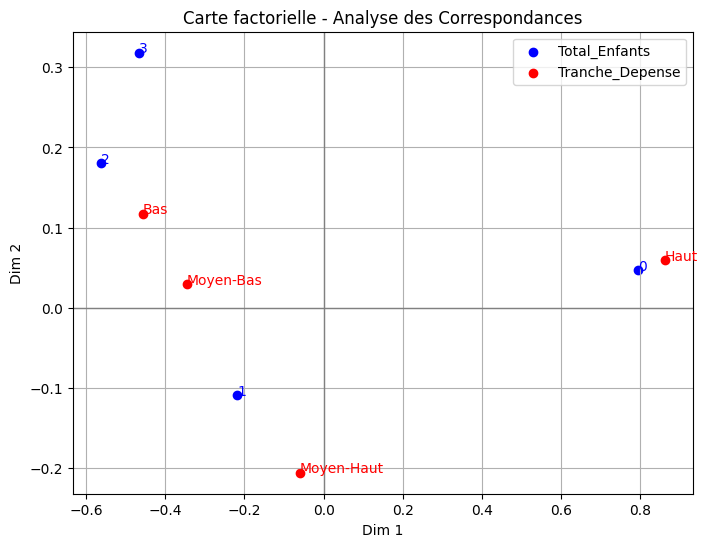

Cos² de Total_Enfants :
                      0         1
Total_Enfants                    
0              0.996523  0.003477
1              0.800296  0.199704
2              0.906648  0.093352
3              0.682711  0.317289
Cos² de Tranche_Dépense :
                        0         1
Tranche_Depense                    
Bas              0.938155  0.061845
Moyen-Bas        0.992928  0.007072
Moyen-Haut       0.078318  0.921682
Haut             0.995286  0.004714


In [53]:
# on va maintenant faire une CA entre la variable Total_Enfants et la variable Depense_Total

table = pd.crosstab(marketing['Total_Enfants'], marketing['Tranche_Depense'])

print(table)

ca = prince.CA(n_components=2, random_state=42)
ca = ca.fit(table)

# Récupérer les coordonnées des lignes et colonnes
row_coords = ca.row_coordinates(table)
col_coords = ca.column_coordinates(table)

# Création du graphique
fig, ax = plt.subplots(figsize=(8, 6))

# Affichage des lignes (modalités de la première variable)
ax.scatter(row_coords[0], row_coords[1], label='Total_Enfants', color='blue')
for i, txt in enumerate(row_coords.index):
    ax.text(row_coords.iloc[i, 0], row_coords.iloc[i, 1], str(txt), color='blue')

# Affichage des colonnes (modalités de la deuxième variable)
ax.scatter(col_coords[0], col_coords[1], label='Tranche_Depense', color='red')
for i, txt in enumerate(col_coords.index):
    ax.text(col_coords.iloc[i, 0], col_coords.iloc[i, 1], str(txt), color='red')

# Axes et titre
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)
ax.set_title("Carte factorielle - Analyse des Correspondances")
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
plt.legend()
plt.grid(True)
plt.show()

# Coordonnées des lignes
row_coords = ca.row_coordinates(table)

# Inertie totale par point (somme des carrés des coordonnées sur toutes les dimensions)
row_inertia = (row_coords**2).sum(axis=1)

# Cos² sur chaque dimension = coordonnée² / inertie
row_cos2 = (row_coords**2).div(row_inertia, axis=0)

print("Cos² de Total_Enfants :")
print(row_cos2)

# Coordonnées des colonnes
col_coords = ca.column_coordinates(table)

# Inertie totale
col_inertia = (col_coords**2).sum(axis=1)

# Cos²
col_cos2 = (col_coords**2).div(col_inertia, axis=0)

print("Cos² de Tranche_Dépense :")
print(col_cos2)

## Analyse

On remarque avec la CA que les clients qui n'ont pas d'enfants sont très proches de la catégorie "Haut" de Dépenses. On en déduit que le fait de ne pas avoir d'enfants implique des dépenses plus importantes sur le site. A contrario, quand on a 2 ou 3 enfants, les dépenses sont plus basses (proche de bas et moyen bas).